# Recommendations with IBM

In this notebook, I will be creating recommendation systems using real data from the IBM Watson Studio platform. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar
import project_tests as t
import pickle

from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import RegexpTokenizer,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [4]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [31]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
article_counts = df.groupby('email')['article_id'].count()
article_counts

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

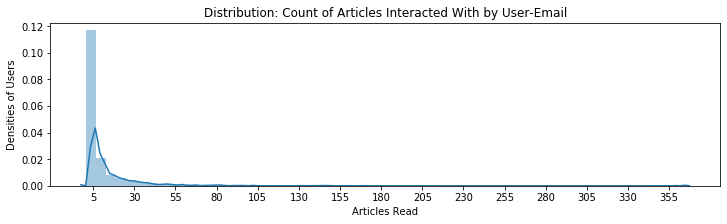

In [7]:
fig = plt.figure(figsize=(12,3))
sns.distplot(article_counts,bins=60,norm_hist=True)
plt.title("Distribution: Count of Articles Interacted With by User-Email")
ticks = np.arange(5,356,25)
plt.xticks(ticks,labels=ticks)
plt.xlabel('Articles Read')
plt.ylabel('Densities of Users')
plt.show()

In [8]:
median_val = np.quantile(article_counts,.5)
max_views_by_user = article_counts.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
df_content['article_id'].nunique()

1051

In [10]:
df_content.shape[0]

1056

In [11]:
df_content = df_content.drop_duplicates('article_id')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
unique_articles = df['article_id'].nunique()
total_articles = df_content['article_id'].nunique()
unique_users = df['email'].nunique()
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
most_viewed_article_id = df.groupby('article_id')['email'].count().idxmax()
max_views = df.groupby('article_id')['email'].count()[most_viewed_article_id]

In [14]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [15]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [43]:
sol_1_dict

{'`50% of individuals have _____ or fewer interactions.`': 3.0,
 '`The total number of user-article interactions in the dataset is ______.`': 45993,
 '`The maximum number of user-article interactions by any 1 user is ______.`': 364,
 '`The most viewed article in the dataset was viewed _____ times.`': 937,
 '`The article_id of the most viewed article is ______.`': '1429.0',
 '`The number of unique articles that have at least 1 rating ______.`': 714,
 '`The number of unique users in the dataset is ______`': 5148,
 '`The number of unique articles on the IBM platform`': 1051}

In [16]:
df['article_id'] = df['article_id'].astype(str)

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = np.array([])
    
    # Creating a sorted list of each article_id of length n
    top_articles_idx = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).iloc[:n].index
    
    # For each article_id, gets article name and appends to array
    for idx in top_articles_idx:
        art_name = df[df['article_id']==idx]['title'].values[0]
        top_articles = np.append(top_articles,art_name)
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).iloc[:n].index
    
 
    return top_articles 

In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Dropping duplicates to count only unique user-article interactions
    df = df.drop_duplicates(subset=['user_id','article_id'])
    
    # Creating matrix
    user_item=df.groupby(['user_id','article_id']).count().unstack()
    
    return user_item

user_item = create_user_item_matrix(df)

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_item = user_item.fillna(0)
    user_vector = user_item.loc[user_id]
    similarity_vector = np.dot(user_item,user_vector)
    # sort by similarity
    sorted_idxs = np.argsort(similarity_vector)[::-1]
    # create list of just the ids
    sorted_user_ids = user_item.reset_index()['user_id'].iloc[sorted_idxs]
    # remove the own user's id
    most_similar_users = sorted_user_ids[sorted_user_ids != user_id]
    return most_similar_users.values         

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [200]:
def get_article_names(article_ids, df=df,title_column='title'):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = np.array([])
    for aid in article_ids:
        name = df[df['article_id']==aid][title_column].values[0]
        article_names = np.append(article_names,name)

    return article_names

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id].notnull()].index.get_level_values(1)
    article_names = get_article_names(article_ids)
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = np.array([])
    
    similar_users = find_similar_users(user_id)
    
    for sim_user in similar_users:
        article_ids, article_names = get_user_articles(sim_user)
        recs = np.append(recs,article_ids)
        if len(recs) >= m:
            break
    
    return recs[:m]

In [29]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['access db2 warehouse on cloud and db2 with python',
       'tensorflow quick tips',
       'apache spark lab, part 1: basic concepts',
       'categorize urban density',
       'classify tumors with machine learning',
       'country statistics: life expectancy at birth',
       'finding optimal locations of new store using decision optimization',
       'gosales transactions for naive bayes model',
       'predict loan applicant behavior with tensorflow neural networking',
       'putting a human face on machine learning'], dtype='<U66')

In [30]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [32]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Filling missing values with 0
    user_item = user_item.fillna(0)
    # Creating vector for the given user
    user_vector = user_item.loc[user_id]
    # Similarity vector taken by the dot product of the user-item matrix with the user vector
    similarity_vector = np.dot(user_item,user_vector)
    # Sorting the similarity vector - first taking the indexes, then sorting
    sorted_idxs = np.argsort(similarity_vector)[::-1]
    similarity_vector = np.sort(similarity_vector)[::-1]
    # Reset index
    sorted_user_ids = user_item.iloc[sorted_idxs].index
    # Collecting number of user-item interacctions for each user
    interactions = user_item.reindex(sorted_user_ids).sum(axis=1).values
    
    # Creating neighbors_df
    neighbors_df = pd.DataFrame({'user_id':sorted_user_ids.values,
                                 'similarity':similarity_vector,
                                 'interactions':interactions})
    # Removing own user's ID and sorting
    neighbors_df = neighbors_df[neighbors_df['user_id'] != user_id]\
        .sort_values(['similarity','interactions'],ascending=False)
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = np.array([])
    # Getting articles the given user has already seen
    seen_article_ids, seen_article_names = get_user_articles(user_id)
    # Getting neighbors DF sorted by similarity and total interactions by user
    neighbors_df = get_top_sorted_users(user_id)
    
    # For each similar user...
    for user in neighbors_df['user_id']:
        # Breaking if length of recommendations is greater than requested no. recs
        if len(recs) >= m:
            break
        # Getting article IDs and names for each similar user
        article_ids, article_names = get_user_articles(user)
        # Sorting article IDs by most interactions
        sorted_article_ids = user_item['title'][article_ids].sum().sort_values(ascending=False).index
        # Appending recs then filtering out articles the given user has already seen
        recs = np.append(recs,sorted_article_ids)
        recs = recs[~np.isin(recs,seen_article_ids)]
        
    rec_names = get_article_names(recs)
    return recs[:m], rec_names[:m]

In [33]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0' '1429.0' '1314.0' '1271.0' '43.0' '1351.0' '1336.0' '1368.0'
 '151.0' '1338.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports'
 'use deep learning for image classification'
 'healthcare python streaming application demo'
 'customer demographics and sales'
 'deep learning with tensorflow course by big data university'
 'model bike sharing data with spss'
 'learn basics about notebooks and apache spark'
 'putting a human face on machine learning' 'jupyter notebook tutorial'
 'ml optimization using cognitive assistant']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [34]:
user1_most_sim = get_top_sorted_users(1)['user_id'].iloc[0]
user131_10th_sim = get_top_sorted_users(131)['user_id'].iloc[10]

In [35]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

If we aren't given any information about a user (say, a new user), we cannot use the collaborative filtering technique used above because it requires user information to find similar users that we can use as a basis for our recommendations.

In this case, we can provide new users Knowledge-Based recommendations, which were covered in [earlier](#Rank) in the notebook, where we came up with functions that let us recommend most popular movies by number of interactions. This doesn't personalize recommendations, but it allows us to recommend popular items without knowing anything about the user we're recommending the items to.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [36]:
new_user = '0.0'

new_user_recs = get_top_article_ids(10)

In [37]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [39]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [74]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize (text):
    # Tokenizing text
    tokens = tokenizer.tokenize(text)
    # Removing stop words
    tokens_nostop = [w for w in tokens if w not in stopwords.words('english')]
    # Lemmatizing
    lemmed = [WordNetLemmatizer().lemmatize(w) for w in tokens_nostop]
    lemmed_2 = [WordNetLemmatizer().lemmatize(w,pos='v') for w in lemmed]
    
    return lemmed_2

In [105]:
def text_matrix(text_series, ids):
    '''
    INPUT:
    text_series: Series containing the text that you want to use as the basis for content recommendations
    ids: ids used to identify each row of text
    
    OUTPUT:
    DataFrame containing matrix of articles by words using TFIDF vectors for each article
    
    '''
    # Tf-idf vectorizing the doc descriptions
    tfidf = TfidfVectorizer(tokenizer=tokenize)
    doc_desc_sparse = tfidf.fit_transform(text_series)
    # Creating matrix of words to article ids
    id_desc_matrix = pd.DataFrame(data=doc_desc_sparse.todense(),index=ids)
    
    return id_desc_matrix

def eucl_dist(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    euc - the euclidean distance between x and y
    '''  
    return np.sqrt(sum((x-y)**2))

In [97]:
content_matrix = text_matrix(df_content['doc_description'].fillna('_'),df_content['article_id'])

In [127]:
def make_similarity_matrix():
    '''
    INPUT
    None
    
    OUTPUT
    similarity matrix containing article-article combos with their euclidean distance
    
    '''
    n = content_matrix.shape[0]
    article_1 = np.array([])
    article_2 = np.array([])
    distances = np.array([])

    with progressbar.ProgressBar(max_value=n) as bar:
        i = 0
        # Looping through all articles
        for art_1_idx in content_matrix.index:
            for art_2_idx in content_matrix.index:
                # Not computing distance between the same article
                if art_1_idx == art_2_idx:
                    continue
                article_1 = np.append(article_1,art_1_idx)
                article_2 = np.append(article_2,art_2_idx)

                art_1_vector = content_matrix.loc[art_1_idx]
                art_2_vector = content_matrix.loc[art_2_idx]

                distance = eucl_dist(art_1_vector,art_2_vector)
                distances = np.append(distances,distance)
            i += 1
            bar.update(i)

        similarity_matrix = pd.DataFrame({'article_1':article_1,'article_2':article_2,'distance':distances})
    
    return similarity_matrix

In [128]:
similarity_matrix = make_similarity_matrix()

100% (1051 of 1051) |####################| Elapsed Time: 7:47:51 Time:  7:47:51


In [129]:
similarity_matrix.head()

,article_1,article_2,distance
0,0.0,1.0,1.414214
1,0.0,2.0,1.414214
2,0.0,3.0,1.414214
3,0.0,4.0,1.401215
4,0.0,5.0,1.382741


In [232]:
def get_user_popular_articles(user_id,n_articles=5,df=df):
    '''
    INPUT
    user_id: ID of the user
    n_articles: number of articles to return
    
    OUTPUT
    list of article_ids sorted by most viewed by users
    '''
    art_ids, art_names = get_user_articles(user_id)
    df = df[df['article_id'].isin(art_ids)]
    sorted_idxs = df.groupby('article_id').count().sort_values('title',ascending=False).index.values
    return sorted_idxs[:n_articles]

In [322]:
def make_content_recs(article_id,n_recs):
    '''
    INPUT
    article_id: id of the article to recommend
    n_recs: number of articles to recommend
    
    OUTPUT:
    Series of top n_recs recommendations based on euclidean distance
    '''
    article_id = float(article_id)
    sim_mat = similarity_matrix[similarity_matrix['article_1']==article_id]
    sorted_arts = sim_mat.sort_values(['distance'],ascending=True)['article_2'].values[:n_recs]
    
    art_names = get_article_names(sorted_arts,df_content,'doc_full_name')
    
    if len(sorted_arts) == 0:
        print(f"Article {article_id} was not included in the similarity matrix, so this has no recommendations.")
    
    return sorted_arts, art_names

In [317]:
def content_recs_user(user_id,n_recs=5):
    '''
    INPUT
    user_id: User ID
    
    OUTPUT
    Content-based recommendations for a given user given as article names
    '''
    recs = np.array([])
    
    try:
        user_pop_articles = get_user_popular_articles(user_id,1000)

        for article in user_pop_articles:
            if len(recs) < n_recs:
                sim_art_idxs,similar_articles = make_content_recs(article,n_recs)
                recs = np.append(recs,similar_articles)
    except:
        pass
    
    if user_id not in df['user_id'].unique():
        print(f"User {user_id} is a new user. No viewed articles are available for content-based rec.")
        print(f"Recommending top {n_recs} articles based on popularity.")
        recs = get_top_articles(n_recs)
    
    return recs

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Overview**

My content-based recommendation system uses euclidean distance between the descriptions of each article.

**The Details**

This system tokenizes and vectorizes using Term Frequency-Inverse Document Frequency (which essentially vectorizes and values words based on how rare they are, which should emphasize relevant/important words). Note that the DataFrame `df_content` was used, which only includes articles 1-1050, which excludes many articles.

Once vectorized, euclidean distance is calculated between each article-article combination and entered into a similarity matrix, which contains 3 columns:
1. First Article
2. Other Article
3. Euclidean Distance between the two Articles.

`make_content_recs` returns a sorted array of article id's and their corresponding document names, and prints a statement in case a given article wasn't included in the similarity matrix used to calculate euclidean distance.

Finally, `content_recs_user` provides a list of recommendations based on the *most popular articles that a given user has read*.

In [323]:
# make recommendations for a brand new user
content_recs_user(6000)

# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs('1427.0',5)


User 6000 is a new user. No viewed articles are available for content-based rec.
Recommending top 5 articles based on popularity.
Article 1427.0 was not included in the similarity matrix, so this has no recommendations.


(array([], dtype=float64), array([], dtype=float64))

In [324]:
# Making a recommendation based on popular articles user 155 has seen
content_recs_user(155,10)

Article 1431.0 was not included in the similarity matrix, so this has no recommendations.
Article 1427.0 was not included in the similarity matrix, so this has no recommendations.
Article 1314.0 was not included in the similarity matrix, so this has no recommendations.
Article 1436.0 was not included in the similarity matrix, so this has no recommendations.
Article 1185.0 was not included in the similarity matrix, so this has no recommendations.
Article 1338.0 was not included in the similarity matrix, so this has no recommendations.
Article 1430.0 was not included in the similarity matrix, so this has no recommendations.
Article 1163.0 was not included in the similarity matrix, so this has no recommendations.


array(['RStudio IDE  Cheat Sheet', 'Overview of RStudio IDE in DSX',
       'Load data into RStudio for analysis in DSX',
       'Upload Files to IBM Data Science Experience Using the Command Line',
       'Analyze Db2 Warehouse on Cloud data in RStudio in DSX',
       'Developing IBM Streams applications with the Python API (Version 1.6)',
       'Data Science Experience Documentation',
       'Use the Machine Learning Library in IBM Analytics for Apache Spark',
       'Use the Machine Learning Library in Spark',
       'Use the Machine Learning Library'], dtype='<U69')

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [335]:
user_item.fillna(0).head()

title                                                               \
article_id   0.0 100.0 1000.0 1004.0 1006.0 1008.0 101.0 1014.0 1015.0 1016.0   
user_id                                                                         
1            0.0   0.0    0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   
2            0.0   0.0    0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   
3            0.0   0.0    0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   
4            0.0   0.0    0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   
5            0.0   0.0    0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   

            ...                                                             
article_id  ... 977.0 98.0 981.0 984.0 985.0 986.0 990.0 993.0 996.0 997.0  
user_id     ...                                                             
1           ...   0.0  0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2           ...   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3           ...   1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4           ...   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5           ...   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 714 columns]

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [340]:
print(user_item.shape)

(5149, 714)


In [336]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item.fillna(0),False)

In [339]:
print(u.shape)
print(s.shape)
print(vt.shape)

(5149, 714)
(714,)
(714, 714)


**Explanation**

In this case, we can perform Numpy's SVD (rather than FunkSVD) because we filled in our user-item matrix with zeros, and thus it has no null values. In cases where we are trying to predict a type of rating for items that users have not yet interacted with or rated, we would not want to fill in the null values. In this case, we are "allowed" to fill in null values with zero because this zero simply represents that the user has not seen the movie yet.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

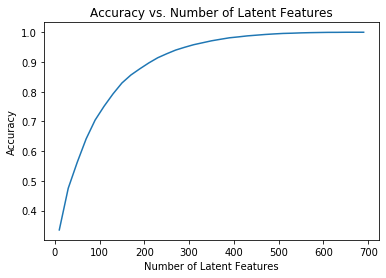

In [342]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item.fillna(0), user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [345]:
user_item.head()

title                                                               \
article_id   0.0 100.0 1000.0 1004.0 1006.0 1008.0 101.0 1014.0 1015.0 1016.0   
user_id                                                                         
1            NaN   NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2            NaN   NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
3            NaN   NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
4            NaN   NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
5            NaN   NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   

            ...                                                             
article_id  ... 977.0 98.0 981.0 984.0 985.0 986.0 990.0 993.0 996.0 997.0  
user_id     ...                                                             
1           ...   NaN  NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2           ...   NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3           ...   1.0  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4           ...   NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5           ...   NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 714 columns]

In [392]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # Creating the user-item matrices
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Filtering out users that are not in the training set
    user_item_test = user_item_test[np.isin(user_item_test.index,user_item_train.index)]
    
    # Getting test user ids and test article ids
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.levels[1].values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [394]:
print('Num Users we can make predictions for in test set:',len(test_idx))
print('Num Users we cannot make predictions for in test set:',df_test['user_id'].nunique()-len(test_idx))
print('Num Articles we can make predictions for in test set:',len(test_arts))
print('Num Articles we cannot make predictions for in test set:',df_test['article_id'].nunique()-len(test_arts))

Num Users we can make predictions for in test set: 20
Num Users we cannot make predictions for in test set: 662
Num Articles we can make predictions for in test set: 574
Num Articles we cannot make predictions for in test set: 0


In [395]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [428]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train.fillna(0)['title'][test_arts],False)

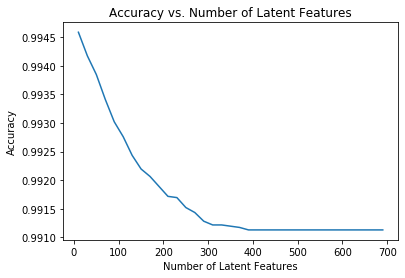

In [432]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[test_idx-1, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.fillna(0), user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Analysis**
From the line plot above, it appears that one latent feature performed the best in terms of accuracy of guessing whether or not users would interact with an article. I don't have an intuition as to why this is the case. I would assume that more latent features would give us more information, and thus have higher accuracy. I have a feeling I'm getting these results because of a few potential reasons... 

1. overfitting to the training matrix
2. high imbalance in the training and testing datasets
3. small testing dataset size

**Next Steps**
In this notebook, I've developed simple systems of recommendation using

1. Knowledge-based recommendations
2. Collaborative filtering
3. Content-based recommendations
4. Matrix factorization with SVD

The best approach likely involves a combination of some or all of these recommendation systems to deal with certain circumstances. If it were up to me, I would A/B Test each promising recommendation system against the benchmark set by the current system (no recommendations), comparing a metric like articles read per dashboard view.

If we have clear evidence that our recommendation systems are working well compared to the "no recommendation" system, I would A/B test these systems against each other or dabble with [Interleaving](https://medium.com/netflix-techblog/interleaving-in-online-experiments-at-netflix-a04ee392ec55) to see which system comes out on top.